In [ ]:
# author: Ghadeer Abualrob 12053417
# Finding the optimal solution for Travelling Salesman Problem (TSP) by the Steepest Ascent Hill Climbing algorithm

In [1]:
import pandas as pd
from itertools import permutations
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import ast
import random
import seaborn as sns
import time
sns.set()

## Text files with random generated distances 

In [2]:

for n_cities in [3, 5, 10, 15, 20, 50]:
    # initialize a matrix of zeros
    distances = np.zeros((n_cities, n_cities))
    for j in range(n_cities):
        for i in range(n_cities):
            # randomly generate distances between cities
            distances[j][i] = random.randint(10, 999)
            distances[i][j] = distances[j][i]  # distance between (1,2) same as (2,1)
        # insure that distance from city to itself is 0
        distances[j][j]=0

    # save distances as matrix to a txt file
    with open(f'cities{n_cities}.txt', 'w') as testfile:
        for d in distances:
            testfile.write(','.join([str(a) for a in d]) + '\n')

## Build the graph

In [17]:
class TSPGraph(object):
    """ 
    TSPGraph class to declare and build cities as graph
    
    self.map : (networkx graph) a fully connected adn unidirectional graph to represent the cities
    self.n_cities : (int) number of cities 
    self.distances_e : (dict) distances between cities
    """
    def __init__(self, txt_file):
        # read distances from a txt file
        self.read_distances(txt_file)
        # build the graph based on txt file data
        self.map = nx.complete_graph(self.n_cities)
        # set distances between cities as self.distances
        self.set_distances()
        
    def read_distances(self, f_name):
        """read a txt file and save its content as a matrix of distances"""
        with open(f_name) as f:
            lines = f.readlines()
        self.distances = [list(ast.literal_eval(l)) for l in lines]
        self.n_cities = len(lines)
        
    def set_distances(self):
        """set distances to edges between cities as dictionary
        self.distances_e = {'(1,2)': 100, ...}
        """ 
        self.distances_e = dict()
        for e in self.map.edges:
            self.distances_e[f'({e[0]},{e[1]})'] = self.distances[e[0]][e[1]]
            self.distances_e[f'({e[1]},{e[0]})'] = self.distances[e[0]][e[1]]
            
    
    def get_neighbors(self, node):
        """get the set of neighbors for a certain node (city)
        retunrn: 
        * list of neighbours
        """
        if node not in self.map.nodes:
            print('ERROR-TSPGraph: this node is not in the graph')
            return
        return [n for n in self.map.neighbors(node)]
    
    def get_distance(self, start, end):
        """get distance between two nodes (cities)
        retunrn: 
        * distance
        """
        # same node (city)
        if start == end:
            return 0
        
        # one of nodes not found
        if start not in self.map.nodes or end not in self.map.nodes:
            print('ERROR-TSPGraph: one of the nodes or both not in the graph')
            return
        return self.distances_e[f'({start},{end})']
    
    def draw_map(self):
        """draw cities as graph"""
        my_pos = nx.spring_layout(self.map, seed = 100)
        nx.draw(self.map, pos=my_pos, node_color = 'pink', edgecolors='black', node_size = 1000, with_labels = True)
         
        

#### Example for a 5-cities graph

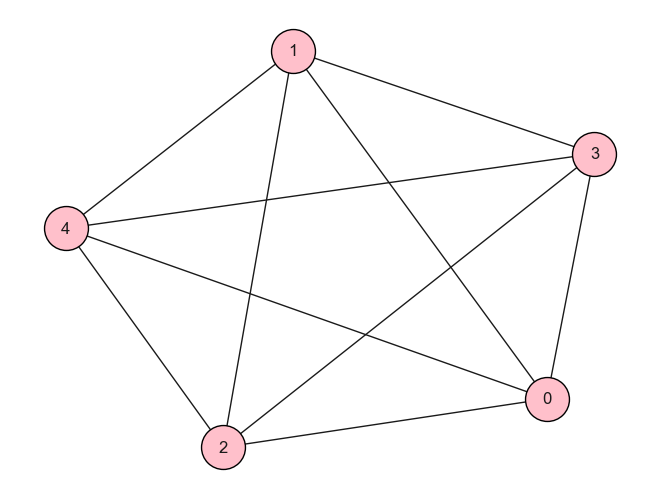

In [18]:
TSP=TSPGraph('cities5.txt')
TSP.draw_map()

# Hill Climbing Algorithm

In [80]:
class HillClimber(object):
    """
    HillClimber class : this class represents a solver that uses the Steepest Ascent Hill Climbing algorithm 
    to solve the TSP of any degree.
    
    self.cities : (TSPGraph) a graph of cities that represent the TSP map
    """
    def __init__(self, G):
        self.cities=G
        
    def find_solution(self):
        """
        find a random solution or path for TSP, starting from a random node
        return: 
        * distance : final distance for the randoly generated full path 
        * solution : a random generated path from a random starting node
        """
        
        # pick a random start node
        start = random.sample(list(self.cities.map.nodes), 1)[-1]
        # initialize the path with start node, distance with 0
        solution = [start]
        distance = 0
        # next node variable
        to_ = -1
        
        # build a path starting from start node and ending with the same node and calculate the distance
        while to_ != start:
            try:
                # randomly pick one of the node neighbours
                to_ = random.sample(list(set(self.cities.get_neighbors(solution[-1]))-set(solution)), 1)[-1]
            except:
                break
            # append the picked node and calculate distance to it
            solution.append(to_)
            distance += self.cities.get_distance(solution[-2], solution[-1])
            
        # append the starting node and calculate distance to it   
        solution.append(start) 
        distance += self.cities.get_distance(solution[-2], solution[-1])
        return distance, solution 
    
    def search_space_neighbours(self, path):
        """
        get neighbours for a picked path (for a solution) 
        path : list of nodes which we will find its neighbours
        return: 
        * paths : a list of tuples as (distance, path) >> (int, list)
        """
        # initialize the paths as list
        paths = []
        # take the inbetween (without end and start) elements of the path which we will find its neighbours
        neighbour = path[1:-1]
        n = self.cities.n_cities-1
        
        # when there is 2 inbetween elements just reverse them and return the new path with its distance
        if n <= 2:
            path[1:-1] = reversed(path[1:-1])
            return [(self.evaluate(path.copy()),path.copy())]
        
        # more than 2 inbetween elements, iterate over n*n and get list of paths
        for i in range(n*(n)):
            
            while path in [p[1] for p in paths]:
                # get a random sample from inbetween elements 
                neighbour = random.sample(neighbour, len(neighbour))
                # assign inbetween elements to the new random ones
                path[1:-1] = neighbour.copy()
            # append the neighbour if it is not in the paths list 
            paths.append((self.evaluate(path.copy()),path.copy()))
        return paths
    
    
    def evaluate(self, path):
        """calculate distances as an evaluation function"""
        return sum([self.cities.get_distance(path[i], path[i+1]) for i in range(len(path)) if i+1!= len(path)])
    
    
    def solve(self, max_t, random_best = True):
        """
        Steepest Ascent Hill Climbing Algorithm
        max_t : number of iterations
        random_best : wether to start with a random best or find best for hill climber 
        return:
        * best : best solution or the shortest path or cycle in which we can visit every city once with lowest cost 
        """
        if not random_best:
            bests=[]
            for i in range(0,20):
                p = self.find_solution()
                bests.append(p)

            bests.sort(reverse=False)
            best = bests[0]
        else :
            # pick a best solution randomly
            best = self.find_solution()
        
        # iterate over max_t to find better solution
        for i in range(max_t):
#             print('\n',i)
            local = False
            # pick a random solution and check its neighbours
            cp = self.find_solution()
#             print('cp :for: ', cp)
            # iterate to find best in a neighbourhood
            while not local:
                neighbors = self.search_space_neighbours(cp[1])
#                 print(neighbors)
                neighbors.sort(key=lambda i:i[0],reverse=False)
                nep = neighbors[0]

                if nep[0] < cp[0]:
                    cp = nep
#                     print('nep :while: ', nep)
#                     print('cp :while: ',cp)
                else :
                    local = True

            if cp[0]<=best[0]:
                best = cp
#                 print('best:', best)
        
        return best
        


# Benchmarks

## Start from a calculated best  

In [58]:
# initialiaze benchmarks
benchmarks=[]

BEST:  (1020.0, [1, 0, 2, 1])
recorded time = 0.6449222564697266 ms


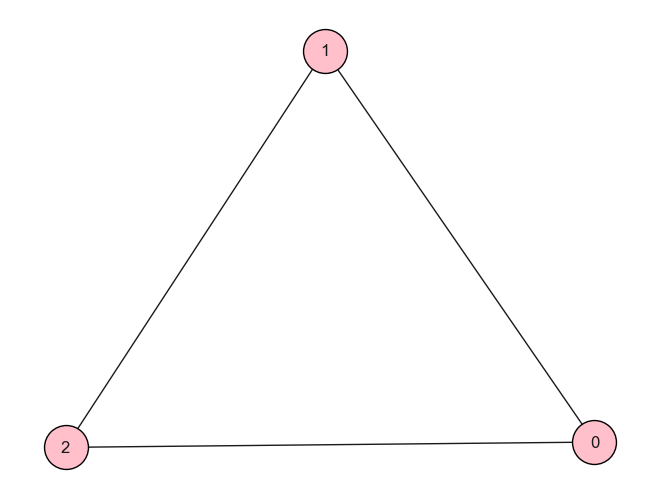

In [59]:
N_CITIES = 3
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (1224.0, [4, 0, 3, 1, 2, 4])
recorded time = 7.529020309448242 ms


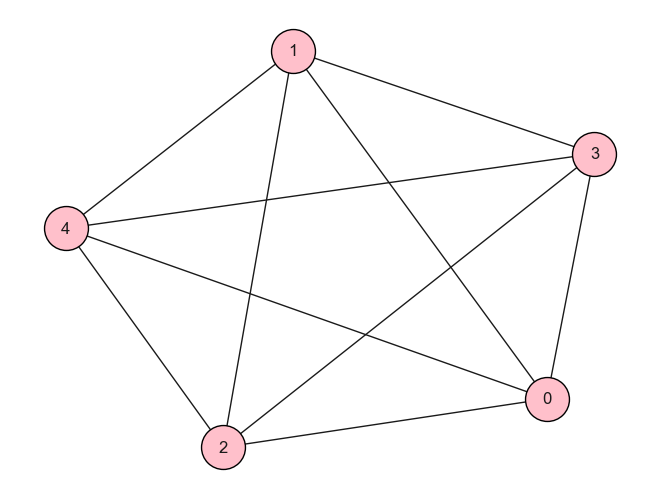

In [60]:
N_CITIES = 5
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (2765.0, [0, 8, 1, 6, 4, 3, 9, 5, 2, 7, 0])
recorded time = 53.02119255065918 ms


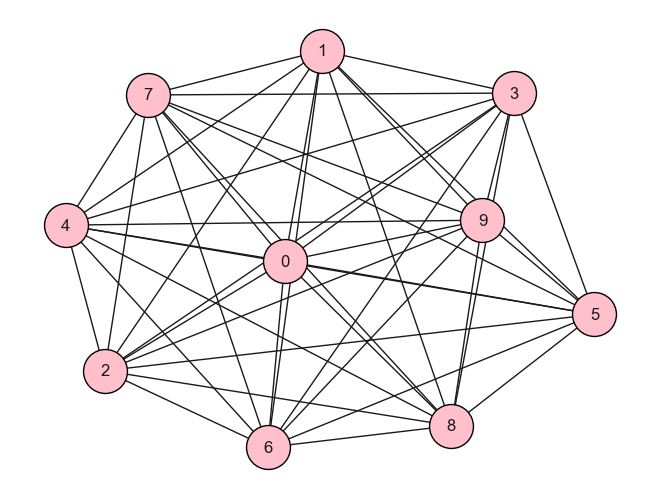

In [61]:
N_CITIES = 10
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (3764.0, [11, 13, 14, 1, 9, 8, 7, 12, 2, 3, 6, 5, 0, 4, 10, 11])
recorded time = 229.80475425720215 ms


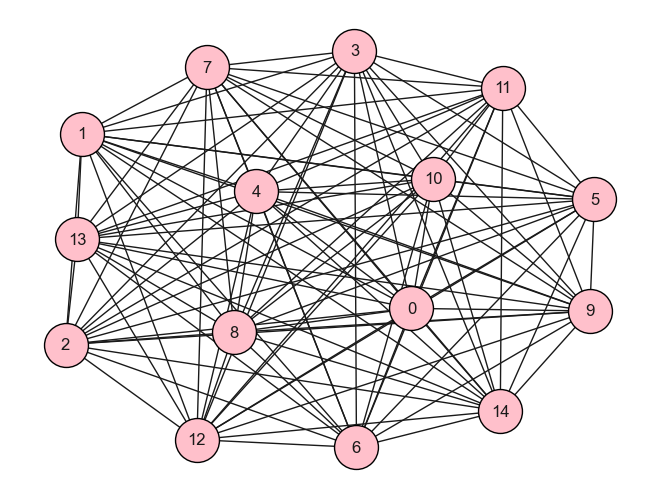

In [62]:
N_CITIES = 15
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (6887.0, [9, 2, 0, 13, 12, 6, 18, 19, 11, 17, 14, 8, 1, 3, 7, 4, 10, 5, 15, 16, 9])
recorded time = 640.5360698699951 ms


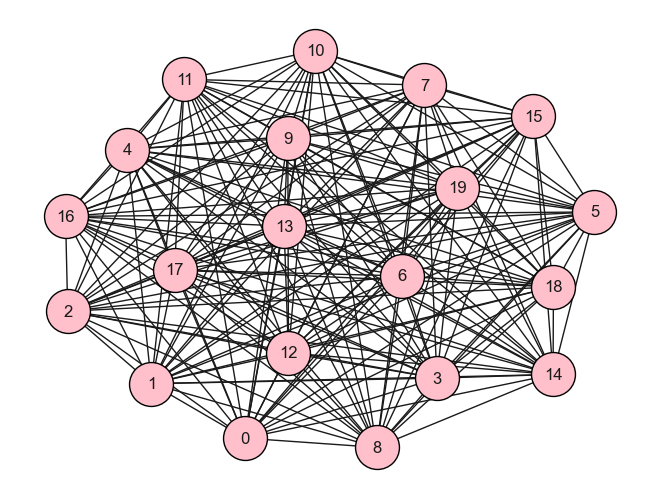

In [63]:
N_CITIES = 20
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (16778.0, [10, 2, 15, 20, 9, 37, 45, 28, 31, 12, 17, 16, 27, 3, 29, 23, 22, 35, 5, 25, 44, 11, 30, 4, 0, 34, 39, 43, 47, 8, 6, 42, 14, 49, 7, 48, 40, 1, 38, 32, 41, 26, 46, 18, 13, 33, 21, 24, 19, 36, 10])
recorded time = 18153.99122238159 ms


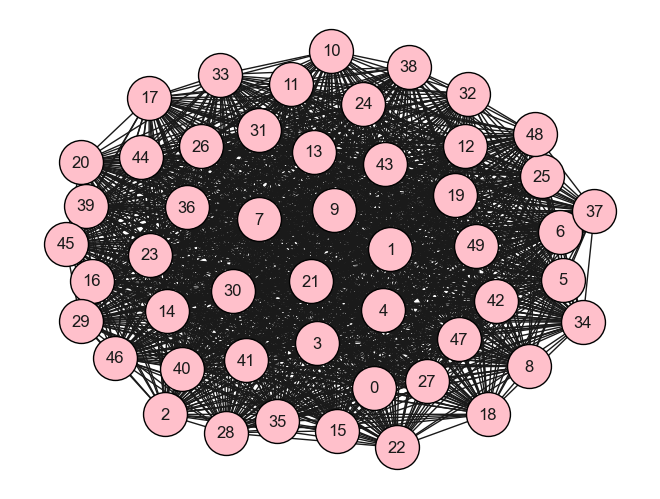

In [64]:
N_CITIES = 50
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

## Getting a best solution as a starting point 

In [65]:
df1 = pd.DataFrame(benchmarks)
df1.columns = ['cities', 'time', 'cost', 'path']
df1['#_cities'] = [3, 5, 10, 15, 20, 50]
df1

cities          time     cost  \
0   3-Cities      0.644922   1020.0   
1   5-Cities      7.529020   1224.0   
2  10-Cities     53.021193   2765.0   
3  15-Cities    229.804754   3764.0   
4  20-Cities    640.536070   6887.0   
5  50-Cities  18153.991222  16778.0   

                                                path  #_cities  
0                                       [1, 0, 2, 1]         3  
1                                 [4, 0, 3, 1, 2, 4]         5  
2                  [0, 8, 1, 6, 4, 3, 9, 5, 2, 7, 0]        10  
3  [11, 13, 14, 1, 9, 8, 7, 12, 2, 3, 6, 5, 0, 4,...        15  
4  [9, 2, 0, 13, 12, 6, 18, 19, 11, 17, 14, 8, 1,...        20  
5  [10, 2, 15, 20, 9, 37, 45, 28, 31, 12, 17, 16,...        50

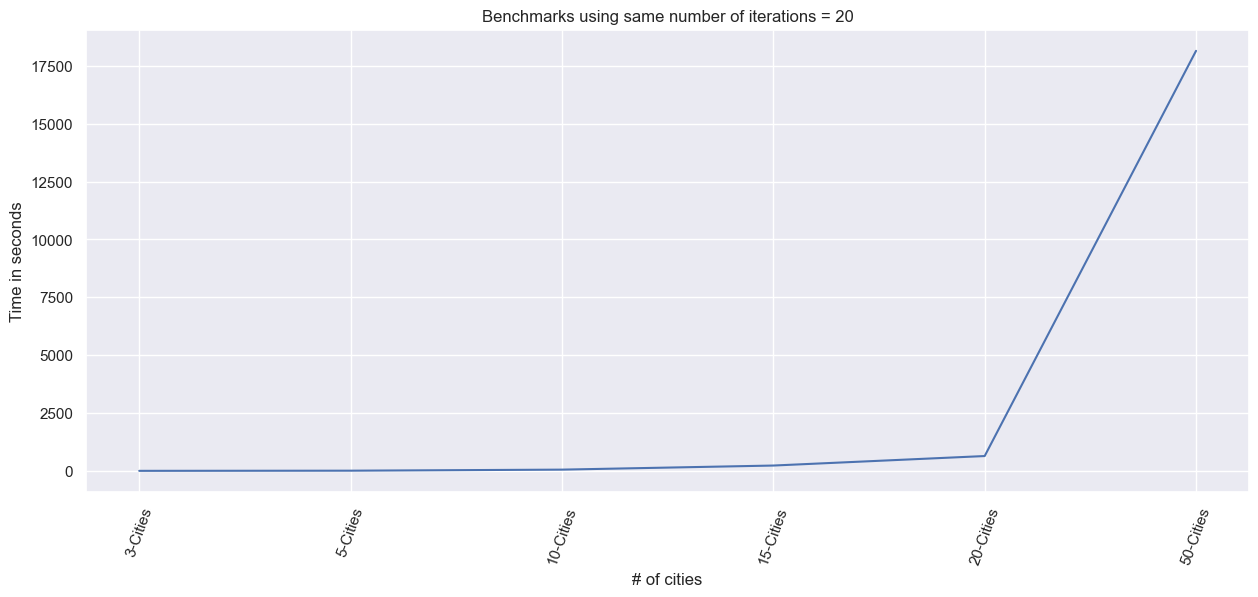

In [66]:
_, ax1 = plt.subplots(1,1, figsize=(15,6))
sns.lineplot(x='cities', y= 'time',data=df1, ax=ax1)
plt.xticks(rotation =70)
plt.title('Benchmarks using same number of iterations = 20')
plt.ylabel('Time in seconds')
plt.xlabel('# of cities')
plt.show()

## Start from a random best

In [83]:
benchmarks2=[]

BEST:  (1020.0, [1, 0, 2, 1])
recorded time = 0.37097930908203125 ms


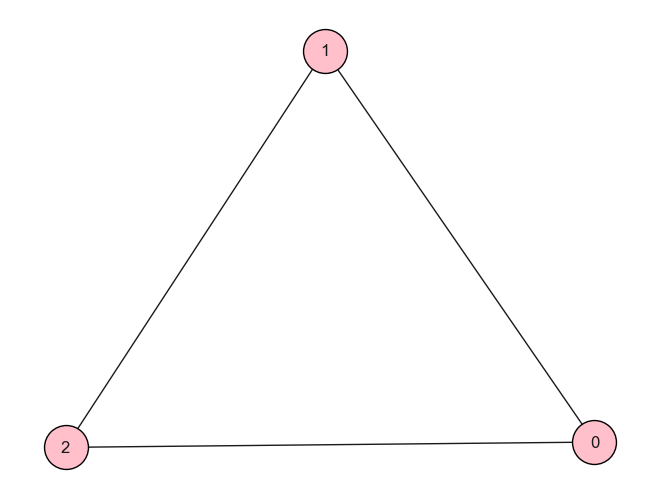

In [84]:
N_CITIES = 3
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, True)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks2.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (1224.0, [0, 4, 2, 3, 1, 0])
recorded time = 4.99415397644043 ms


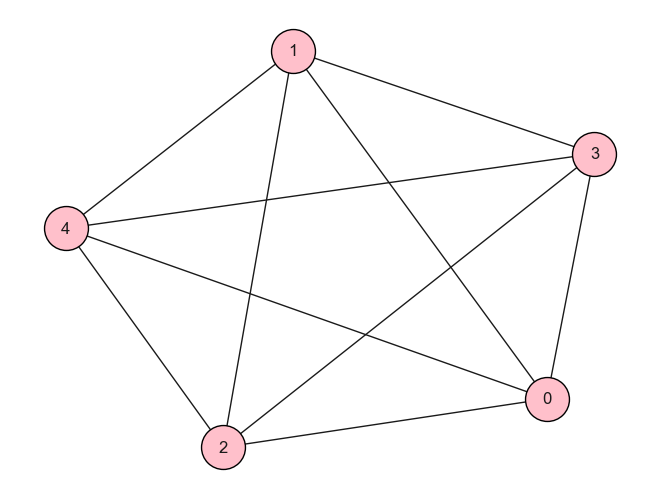

In [85]:
N_CITIES = 5
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, True)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks2.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (2714.0, [9, 0, 8, 7, 4, 1, 3, 2, 5, 6, 9])
recorded time = 53.15113067626953 ms


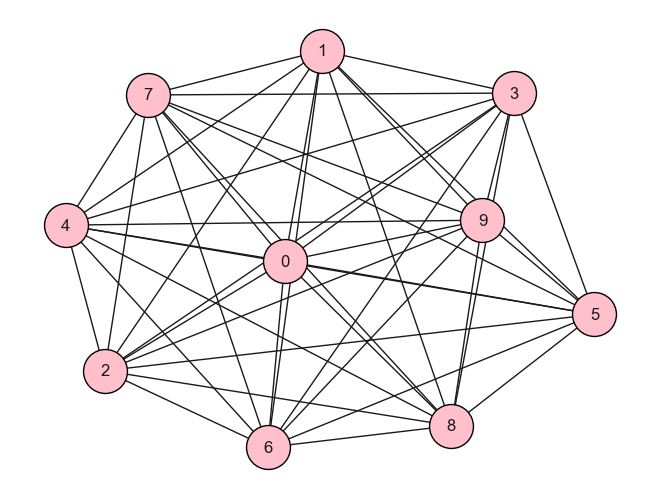

In [86]:
N_CITIES = 10
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, True)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks2.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (3956.0, [11, 14, 12, 1, 3, 13, 2, 6, 8, 10, 5, 4, 0, 9, 7, 11])
recorded time = 214.95771408081055 ms


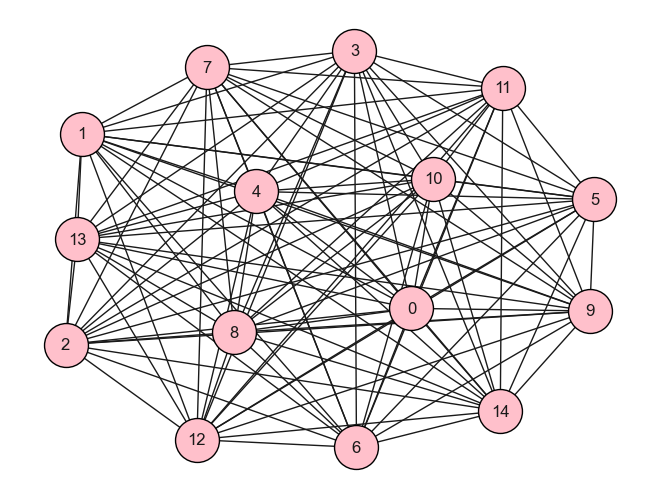

In [87]:
N_CITIES = 15
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, True)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks2.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (6750.0, [13, 3, 12, 1, 9, 17, 14, 5, 10, 19, 11, 8, 4, 7, 18, 2, 0, 15, 6, 16, 13])
recorded time = 597.1338748931885 ms


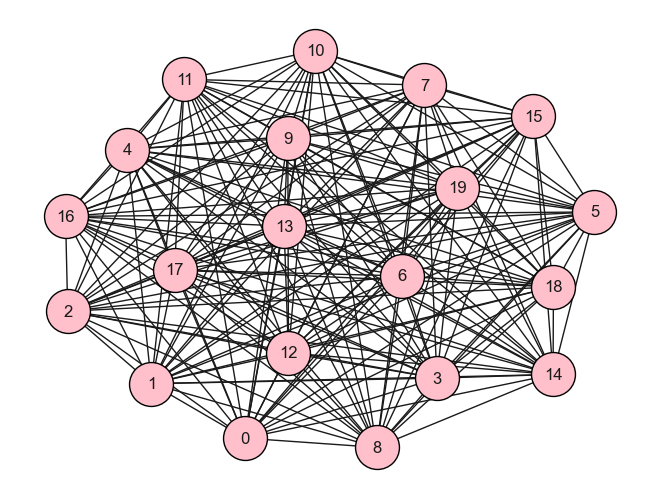

In [88]:
N_CITIES = 20
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, True)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks2.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (16952.0, [40, 44, 46, 3, 7, 26, 25, 27, 29, 33, 48, 47, 2, 31, 41, 4, 23, 45, 49, 5, 39, 6, 28, 24, 16, 17, 21, 18, 19, 20, 14, 43, 1, 8, 13, 12, 10, 11, 22, 0, 30, 32, 36, 42, 34, 38, 15, 37, 9, 35, 40])
recorded time = 14317.840099334717 ms


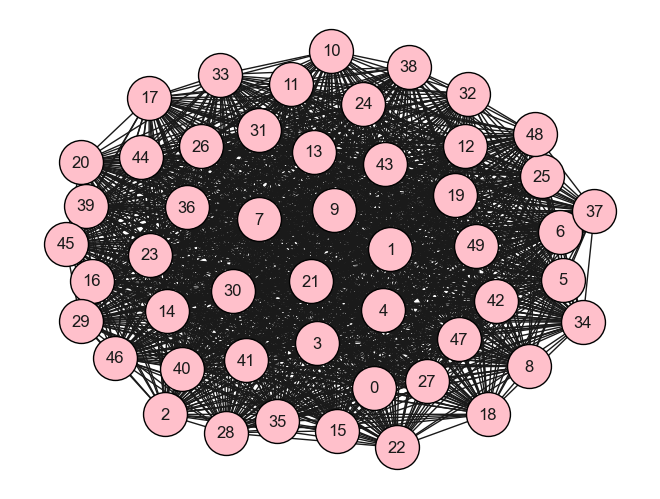

In [89]:
N_CITIES = 50
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, True)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks2.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

## Getting a best solution randomly as a starting point

In [92]:
df2 = pd.DataFrame(benchmarks2)
df2.columns = ['cities', 'time', 'cost', 'path']
df2['#_cities'] = [3, 5, 10, 15, 20, 50]
df2

cities          time     cost  \
0   3-Cities      0.370979   1020.0   
1   5-Cities      4.994154   1224.0   
2  10-Cities     53.151131   2714.0   
3  15-Cities    214.957714   3956.0   
4  20-Cities    597.133875   6750.0   
5  50-Cities  14317.840099  16952.0   

                                                path  #_cities  
0                                       [1, 0, 2, 1]         3  
1                                 [0, 4, 2, 3, 1, 0]         5  
2                  [9, 0, 8, 7, 4, 1, 3, 2, 5, 6, 9]        10  
3  [11, 14, 12, 1, 3, 13, 2, 6, 8, 10, 5, 4, 0, 9...        15  
4  [13, 3, 12, 1, 9, 17, 14, 5, 10, 19, 11, 8, 4,...        20  
5  [40, 44, 46, 3, 7, 26, 25, 27, 29, 33, 48, 47,...        50

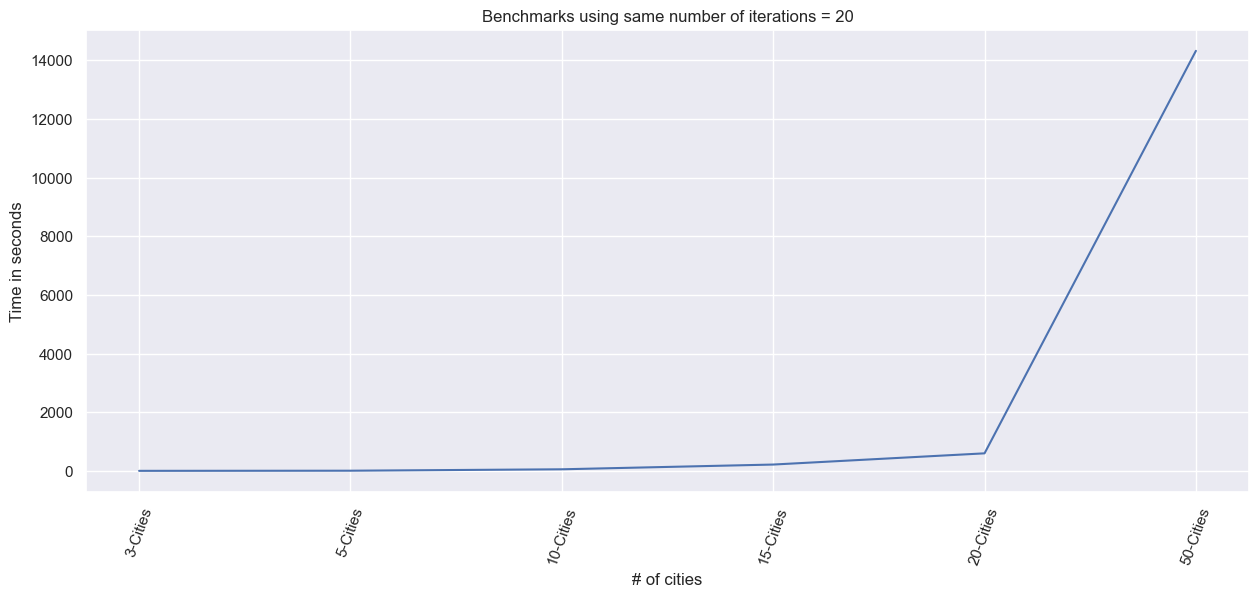

In [93]:
_, ax1 = plt.subplots(1,1, figsize=(15,6))
sns.lineplot(x='cities', y= 'time',data=df2, ax=ax1)
plt.xticks(rotation =70)
plt.title('Benchmarks using same number of iterations = 20')
plt.ylabel('Time in seconds')
plt.xlabel('# of cities')
plt.show()

# Use different number of iteration based on number of nodes and search space

## start with random best

In [68]:
benchmarks1=[]

BEST:  (1020.0, [1, 0, 2, 1])
recorded time = 0.6499290466308594 ms


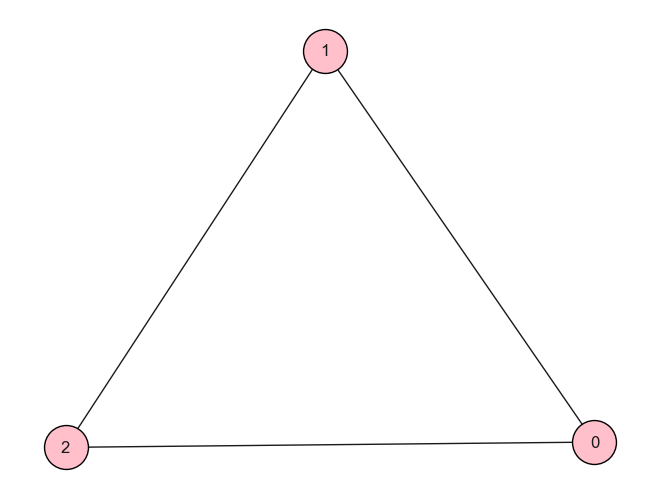

In [69]:
N_CITIES = 3
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks1.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (1224.0, [4, 3, 1, 0, 2, 4])
recorded time = 12.313127517700195 ms


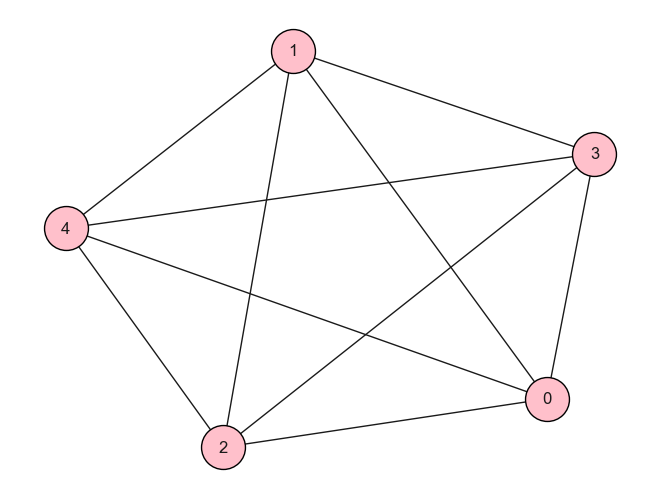

In [70]:
N_CITIES = 5
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 35    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks1.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (2773.0, [7, 0, 9, 4, 6, 3, 1, 8, 2, 5, 7])
recorded time = 188.9350414276123 ms


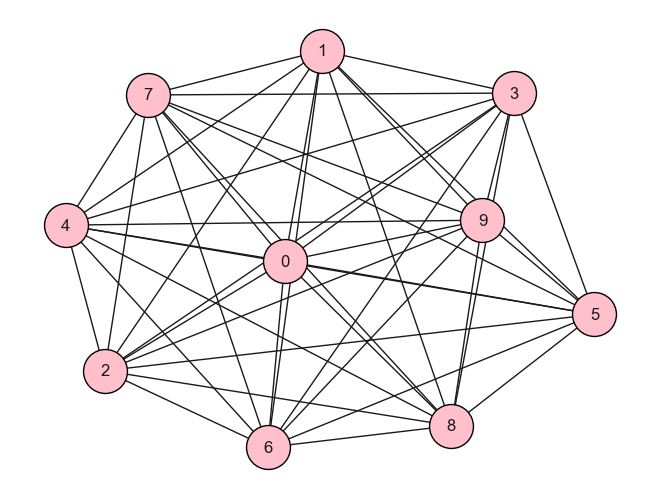

In [71]:
N_CITIES = 10
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 65    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks1.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (3411.0, [12, 10, 5, 7, 11, 13, 0, 14, 3, 1, 8, 2, 4, 9, 6, 12])
recorded time = 1053.091049194336 ms


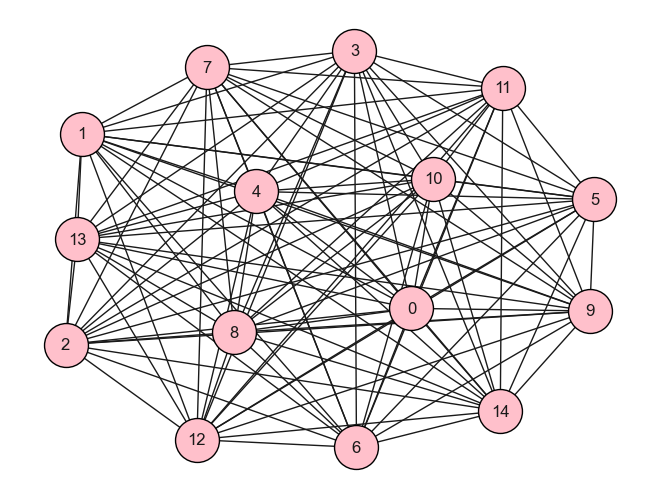

In [72]:
N_CITIES = 15
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 100    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks1.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (5858.0, [4, 1, 11, 7, 12, 10, 3, 8, 15, 0, 18, 2, 16, 13, 19, 9, 17, 6, 5, 14, 4])
recorded time = 4073.899984359741 ms


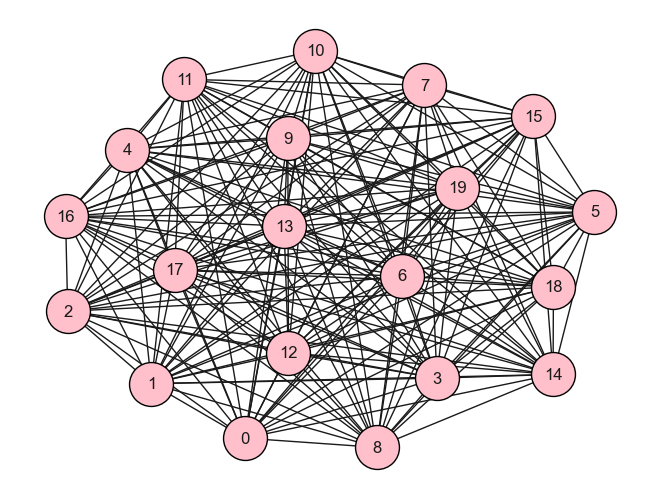

In [73]:
N_CITIES = 20
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 135    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks1.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (15140.0, [22, 3, 20, 23, 37, 32, 12, 31, 25, 38, 14, 27, 10, 5, 35, 8, 41, 17, 43, 0, 36, 40, 4, 16, 15, 28, 11, 47, 33, 9, 29, 2, 24, 6, 19, 49, 46, 39, 42, 26, 1, 44, 34, 13, 7, 48, 21, 18, 30, 45, 22])
recorded time = 250133.76998901367 ms


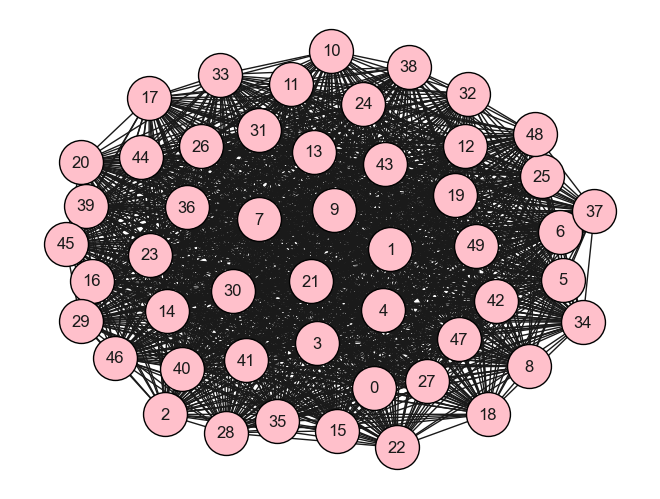

In [74]:
N_CITIES = 50
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 300    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks1.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

In [95]:
df3 = pd.DataFrame(benchmarks1)
df3.columns = ['cities', 'time', 'cost', 'path']
df3['#_cities'] = [3, 5, 10, 15, 20, 50]
df3['iterations'] = [20,35,65,100,135,300]
df3

cities           time     cost  \
0   3-Cities       0.649929   1020.0   
1   5-Cities      12.313128   1224.0   
2  10-Cities     188.935041   2773.0   
3  15-Cities    1053.091049   3411.0   
4  20-Cities    4073.899984   5858.0   
5  50-Cities  250133.769989  15140.0   

                                                path  #_cities  iterations  
0                                       [1, 0, 2, 1]         3          20  
1                                 [4, 3, 1, 0, 2, 4]         5          35  
2                  [7, 0, 9, 4, 6, 3, 1, 8, 2, 5, 7]        10          65  
3  [12, 10, 5, 7, 11, 13, 0, 14, 3, 1, 8, 2, 4, 9...        15         100  
4  [4, 1, 11, 7, 12, 10, 3, 8, 15, 0, 18, 2, 16, ...        20         135  
5  [22, 3, 20, 23, 37, 32, 12, 31, 25, 38, 14, 27...        50         300

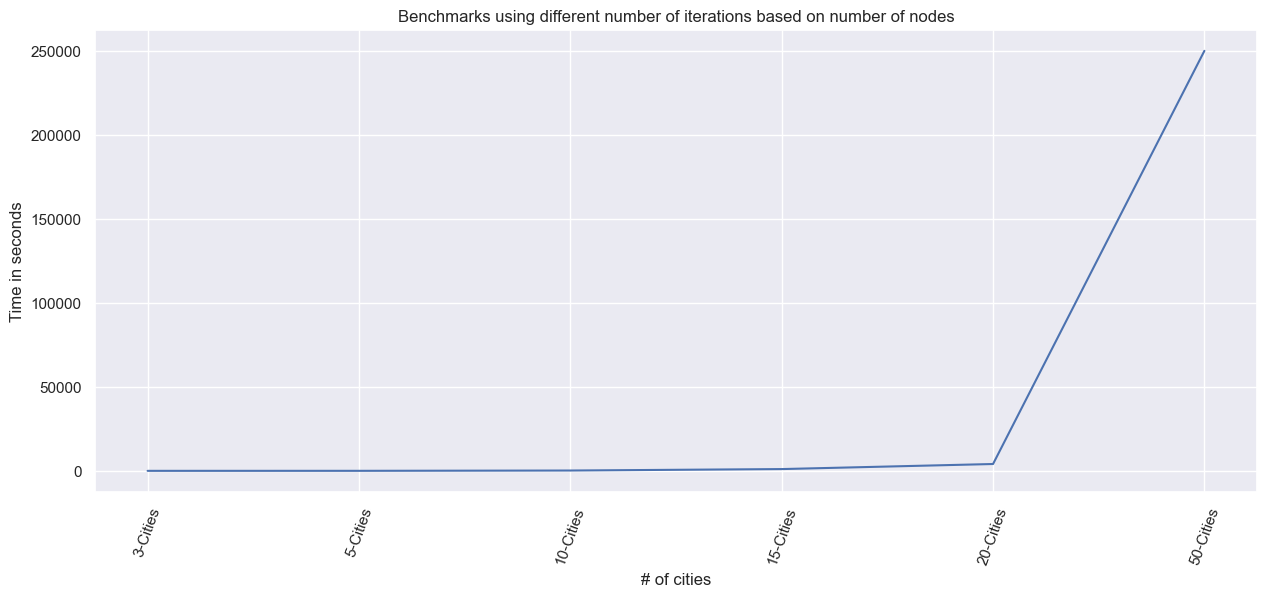

In [82]:
_, ax1 = plt.subplots(1,1, figsize=(15,6))
sns.lineplot(x='cities', y= 'time',data=df3, ax=ax1)
plt.xticks(rotation =70)
plt.title('Benchmarks using different number of iterations based on number of nodes')
plt.ylabel('Time in seconds')
plt.xlabel('# of cities')
plt.show()

## start with calculated best

In [96]:
benchmarks3=[]

BEST:  (1020.0, [0, 1, 2, 0])
recorded time = 0.5841255187988281 ms


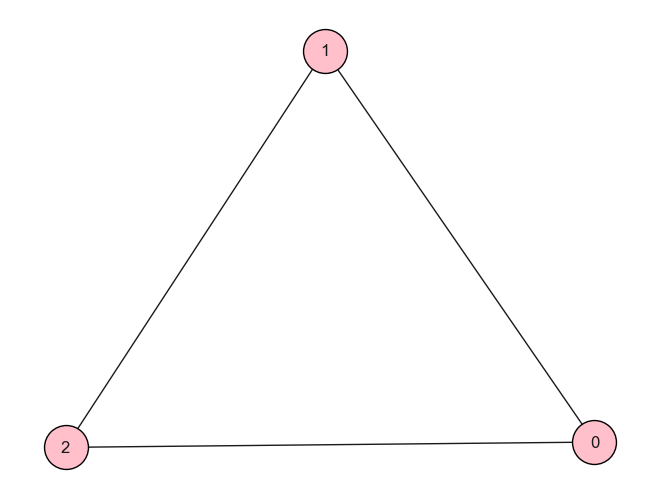

In [97]:
N_CITIES = 3
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 20    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks3.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (1224.0, [0, 1, 3, 2, 4, 0])
recorded time = 8.579015731811523 ms


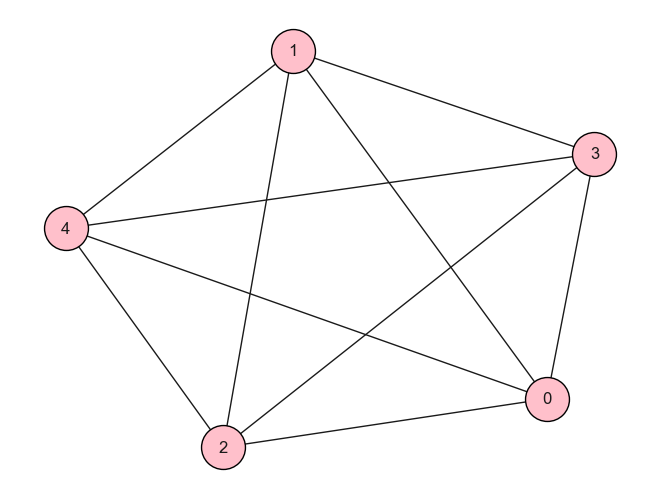

In [98]:
N_CITIES = 5
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 35    
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks3.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (2502.0, [9, 2, 1, 4, 5, 6, 8, 0, 3, 7, 9])
recorded time = 193.8302516937256 ms


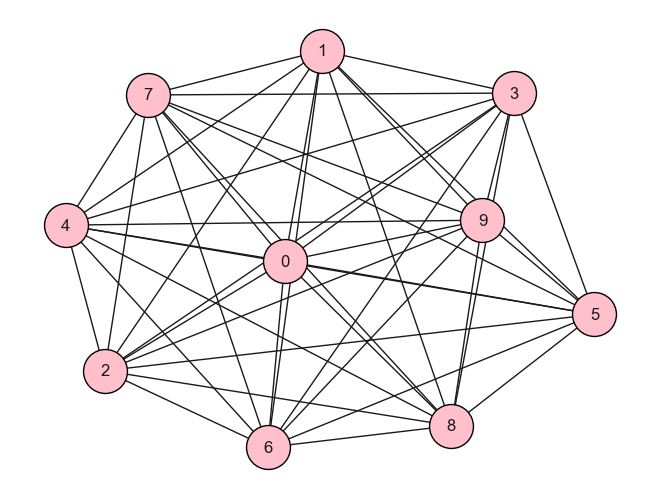

In [99]:
N_CITIES = 10
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 65   
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks3.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (3144.0, [1, 14, 13, 11, 5, 0, 3, 12, 9, 4, 10, 2, 8, 7, 6, 1])
recorded time = 1058.7258338928223 ms


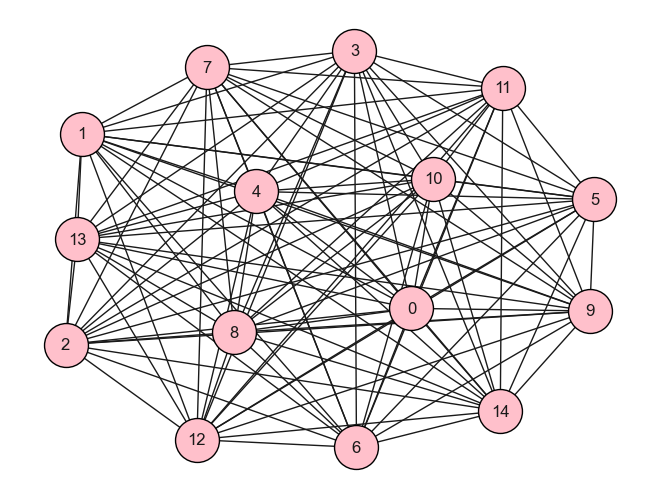

In [100]:
N_CITIES = 15
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 100   
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks3.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (5917.0, [9, 0, 6, 10, 8, 19, 2, 13, 17, 4, 14, 18, 5, 16, 3, 15, 11, 1, 12, 7, 9])
recorded time = 4078.4082412719727 ms


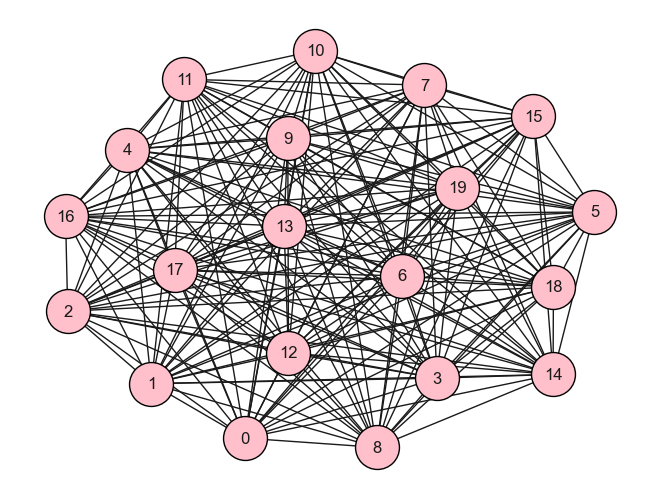

In [101]:
N_CITIES = 20
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 135   
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks3.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

BEST:  (15242.0, [21, 36, 10, 44, 41, 32, 25, 30, 7, 42, 6, 17, 9, 5, 22, 27, 31, 49, 13, 0, 16, 48, 26, 12, 45, 47, 2, 15, 33, 46, 18, 11, 19, 43, 40, 39, 34, 14, 1, 28, 38, 24, 8, 20, 3, 23, 29, 4, 37, 35, 21])
recorded time = 258742.8457736969 ms


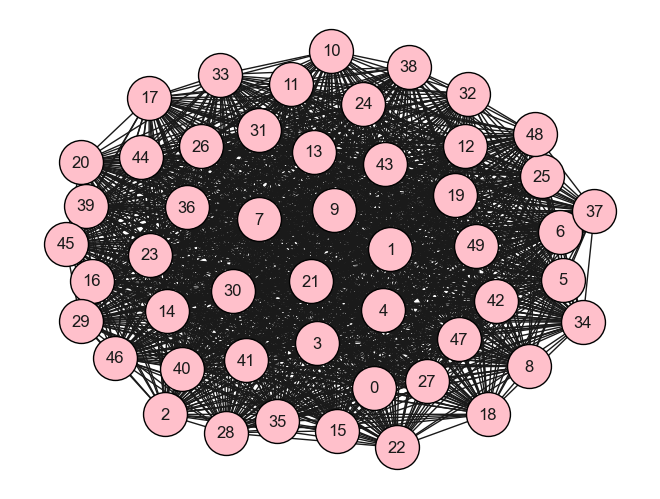

In [102]:
N_CITIES = 50
TSP=TSPGraph(f'cities{N_CITIES}.txt')
TSP.draw_map()

MAX_T = 300   
solver = HillClimber(TSP)

s=time.time()
best = solver.solve(MAX_T, False)
e=time.time()

t = (e-s)*1000
print('BEST: ', best)
print(f'recorded time = {t} ms')
benchmarks3.append([f'{N_CITIES}-Cities', t, best[0], best[1]])

In [104]:
df4 = pd.DataFrame(benchmarks3)
df4.columns = ['cities', 'time', 'cost', 'path']
df4['#_cities'] = [3, 5, 10, 15, 20, 50]
df4['iterations'] = [20,35,65,100,135,300]
df4

cities           time     cost  \
0   3-Cities       0.584126   1020.0   
1   5-Cities       8.579016   1224.0   
2  10-Cities     193.830252   2502.0   
3  15-Cities    1058.725834   3144.0   
4  20-Cities    4078.408241   5917.0   
5  50-Cities  258742.845774  15242.0   

                                                path  #_cities  iterations  
0                                       [0, 1, 2, 0]         3          20  
1                                 [0, 1, 3, 2, 4, 0]         5          35  
2                  [9, 2, 1, 4, 5, 6, 8, 0, 3, 7, 9]        10          65  
3  [1, 14, 13, 11, 5, 0, 3, 12, 9, 4, 10, 2, 8, 7...        15         100  
4  [9, 0, 6, 10, 8, 19, 2, 13, 17, 4, 14, 18, 5, ...        20         135  
5  [21, 36, 10, 44, 41, 32, 25, 30, 7, 42, 6, 17,...        50         300

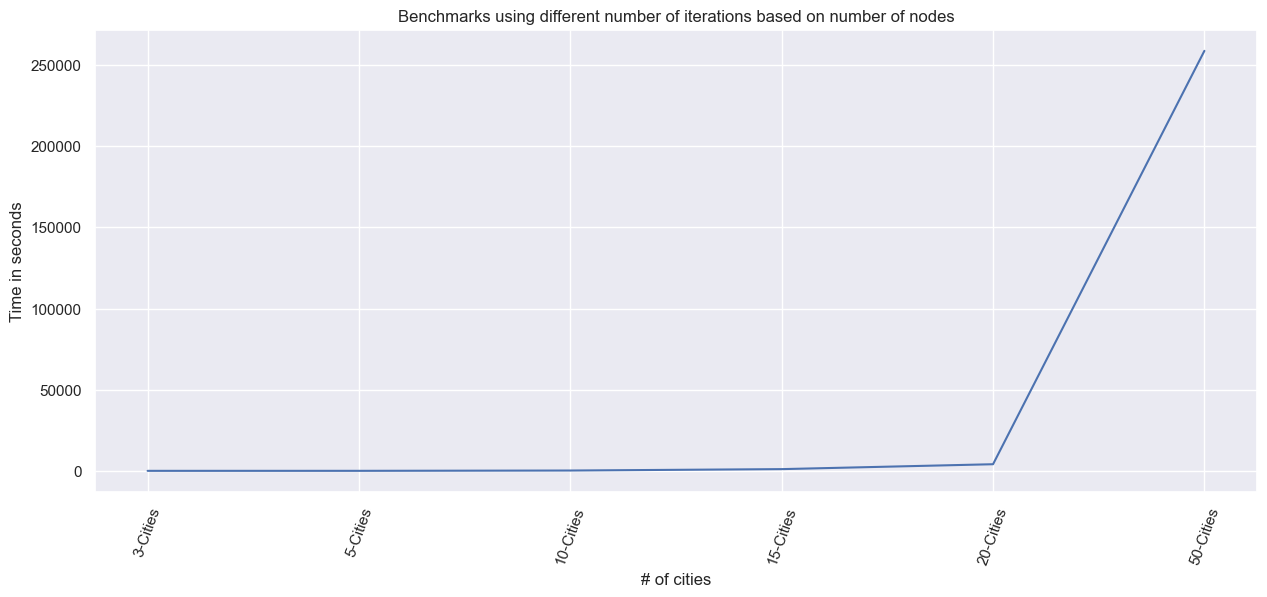

In [105]:
_, ax1 = plt.subplots(1,1, figsize=(15,6))
sns.lineplot(x='cities', y= 'time',data=df4, ax=ax1)
plt.xticks(rotation =70)
plt.title('Benchmarks using different number of iterations based on number of nodes')
plt.ylabel('Time in seconds')
plt.xlabel('# of cities')
plt.show()

# End of Notebook